# Lasso regression on old dataset

In [1]:
library(caret)
library(glmnet)
library(doMC)
library(readr)
library(c060)
library(hash)
library(RColorBrewer)

Loading required package: ggplot2

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-2

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

hash-2.2.6.1 provided by Decision Patterns




In [2]:
library(doParallel)
library(foreach)

The `clean_cancer_old.csv` dataset contains all the 16235 cancer cells. However, the number of genes is reduced to 14297. This is done by eliminating all columns with NaNs.  

In [3]:
rna_old = data.table::fread('/data/severs/clean_cancer_old.csv')

In [4]:
rownames(rna_old) <- rna_old$V1

In [5]:
rna_old$V1 <- NULL

In [6]:
Y = rna_old$ESR1
X = rna_old[, -5052]

In [7]:
X_diff <- X[abs(Y)>0.5,]
Y_diff <- Y[abs(Y)>0.5]

In [8]:
# Funtions
rsq <- function (x, y) cor(x, y) ^ 2
rmse <- function (x, y) sqrt(mean((x-y)^2))
plot_prediction <- function (pred, title_) {
        plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
             ylim=c(min(pred$truth), max(pred$truth)))
        lines(pred$truth, col="red", lw=2)
        legend("topleft", 
               legend=c("Prediction", "Truth",
                        paste("R2: ", substr(toString(r2score), 1, 5)),
                        paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
               fill=c("black","red", "white", "white"))
        title(title_)

        below <- sum((pred$prediction-min(pred$truth))<0)
        above <-  sum((pred$prediction-max(pred$truth))>0)
        if (below>0 || above > 0) {
            print(sprintf("# of predictions outside chart margins: %s below, %s above",below, above))
        }
    }

# Repeated cross validation on differentially expressed

In [9]:
train_ind_diff <- read.csv("/data/severs/trainind_patient_strat_diffexp.csv")$Resample1

In [10]:
x_train <- as.matrix(X[abs(Y)>0.5,][train_ind_diff, ])

In [11]:
x_test <- as.matrix(X[abs(Y)>0.5,][-train_ind_diff, ])

In [12]:
y_train <- Y[abs(Y)>0.5][train_ind_diff]

In [13]:
y_test <- Y[abs(Y)>0.5][-train_ind_diff]

In [17]:
load("/data/xiaoral/rna_metadata.Rdata")

In [18]:
PatientNumberDiffExp <- metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber[abs(Y)>0.5][train_ind_diff]

In [19]:
capture.output(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber[abs(Y)>0.5], file = "/data/severs/BP_patientnumber_diffexp.txt")

In [20]:
tmp <- metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber[abs(Y)>0.5]

In [21]:
length(tmp)

[1] 3459

In [22]:
lambdas <- 10^seq (-0.05, -3, by = -.05)

In [23]:
registerDoMC(cores = 5)

In [24]:
cl <- makeCluster(20) #not to overload your computer
registerDoParallel(cl)

In [479]:
fit_list_ <- foreach(i=1:100, .combine=cbind) %dopar% {
    foldid <- foldids <- balancedFolds(PatientNumberDiffExp, 5)
    cv_lasso <- cv.glmnet(x_train , y_train,
                       nfolds = 5, alpha = 1, lambda = lambdas,
                        standardize=TRUE,
                       type.measure = "deviance", parallel=TRUE)
    list(cv_lasso)
}

ERROR: Error in {: task 1 failed - "could not find function "balancedFolds""


In [480]:
set.seed(2)
fit_list <- rep(0, 100)
mse <- rep(0,100)
r2_scores <- rep(0,100)
for (i in 1:100) {
    foldid <- balancedFolds(PatientNumberDiffExp, 5)
    cv_lasso <- cv.glmnet(x_train , y_train,
                       foldid = foldid, alpha = 1, lambda = lambdas,
                        standardize=TRUE,
                       type.measure = "deviance", parallel=TRUE)
    
    fit_list[i] <- list(cv_lasso)
    mse[i] <- cv_lasso$cvm[match(cv_lasso$lambda.1se, cv_lasso$lambda)]
    r2_scores[i] <- rsq(predict(cv_lasso, newx=x_test), y_test)
}

1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891011121 
2 
3 
4 
5 
1234567891

In [486]:
prediction <- predict(cv_lasso, newx=x_test)
pred <- data.frame(list(prediction, y_test))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(y_test, prediction)
rmsescore <- rmse(y_test, prediction)

In [491]:
max(r2_scores)

[1] 0.3596221

[1] "# of predictions outside chart margins: 2 below, 0 above"


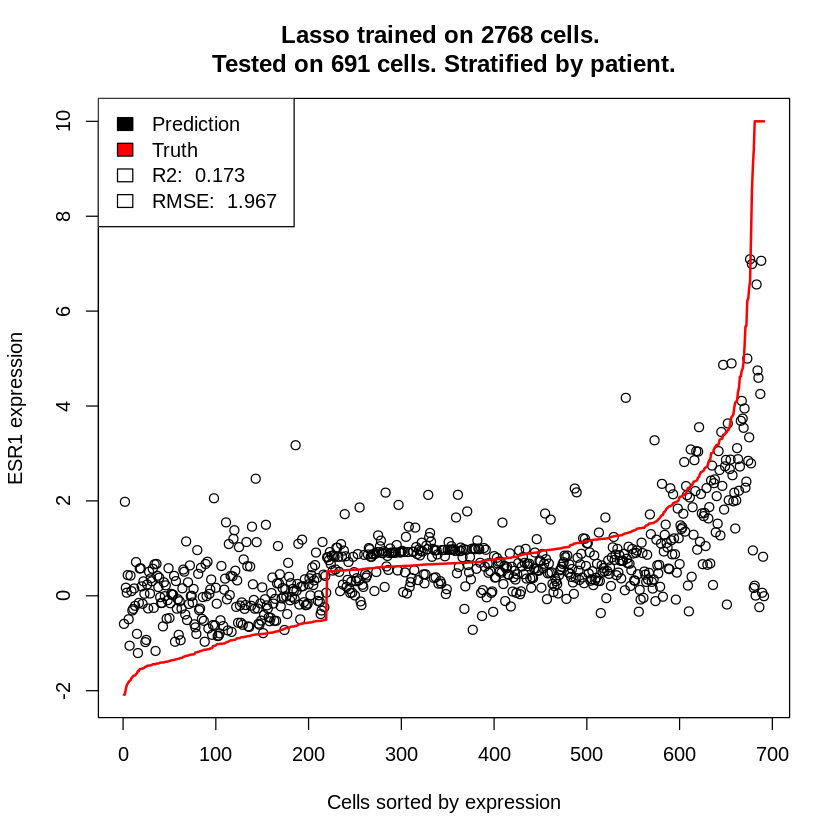

In [500]:
plot_prediction(pred, "Lasso trained on 2768 cells. \nTested on 691 cells. Stratified by patient.")

[1] NA

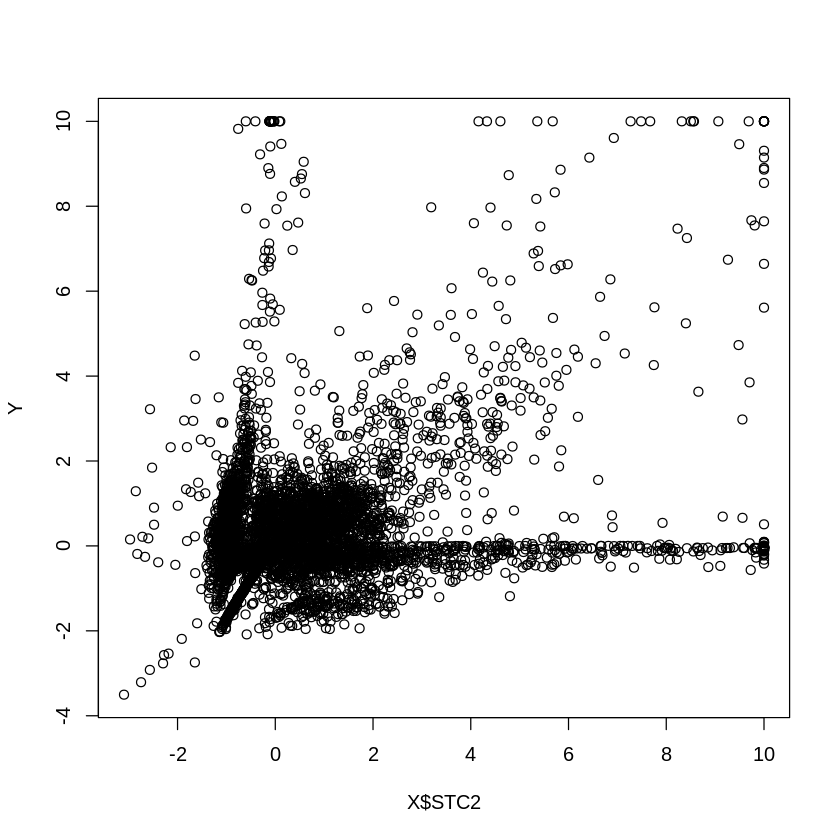

In [528]:
plot(X$STC2, Y)

TRAV26-1
<dbl>
-0.1575081


In [627]:
colnames(X) <- gsub("-", ".", colnames(X))

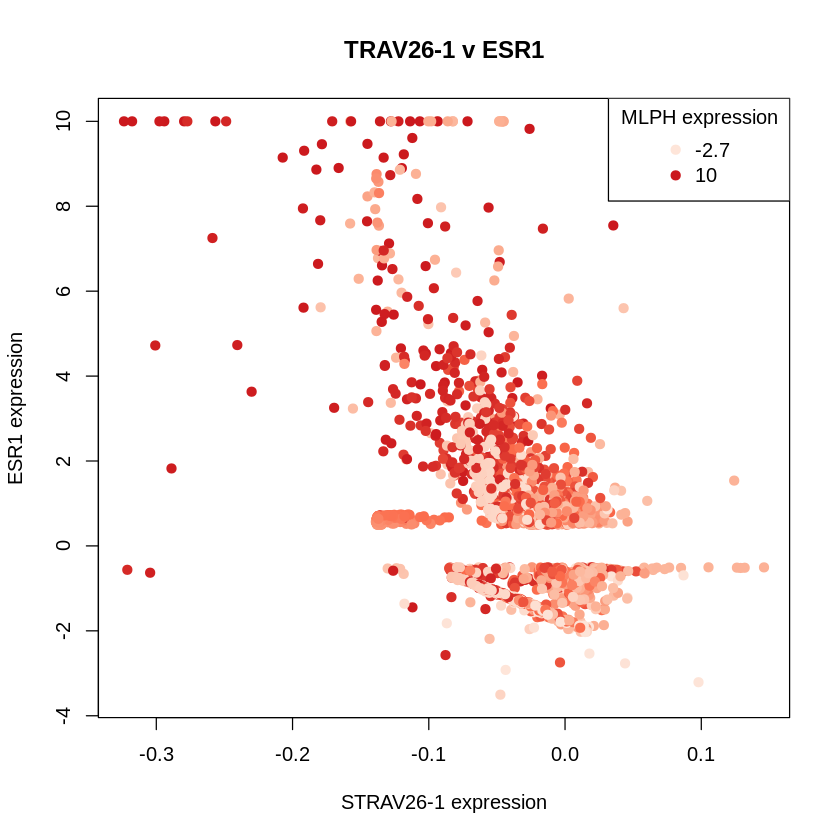

In [684]:
order = findInterval(x_train[,'MLPH'], sort(x_train[,'MLPH']))
plot(x_train[,'TRAV26-1'], y_train, pch=19, col=pal(nrow(x_train))[order], xlab="STRAV26-1 expression", ylab="ESR1 expression")
legend("topright", col=pal(2), pch=19,
   legend=c(round(range(x_train[,'MLPH']), 1)), title="MLPH expression")
title("TRAV26-1 v ESR1")

In [697]:
order = findInterval(X_diff$STC2, sort(X_diff$STC2))

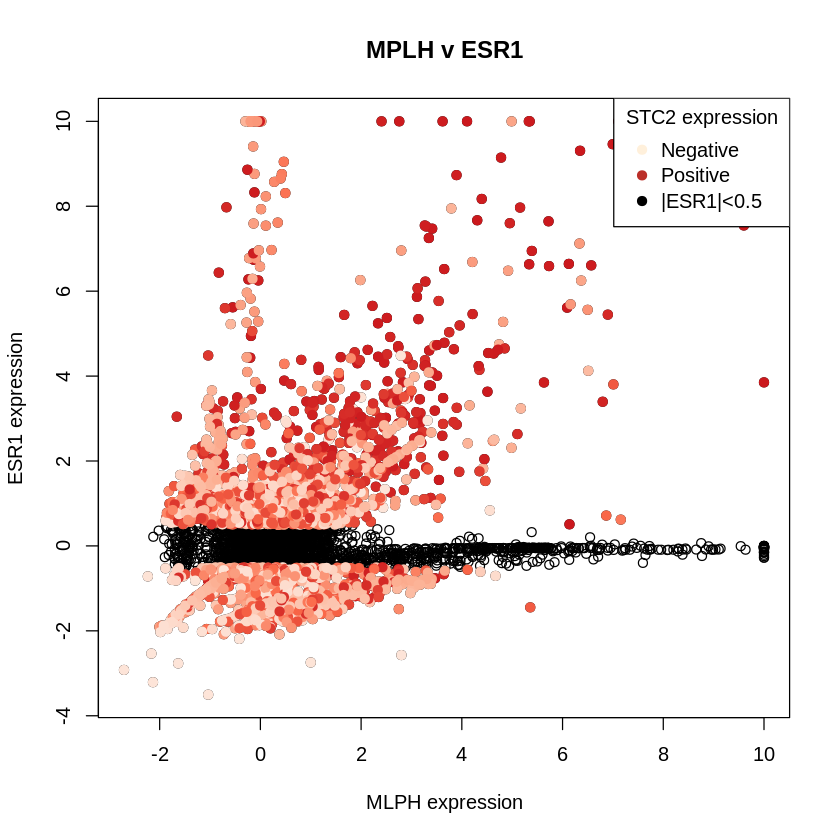

In [703]:
cols = brewer.pal(4, "Reds")
pal = colorRampPalette(c("blue", "red"))
# Use the following line with RColorBrewer
pal = colorRampPalette(cols)
plot(X$MLPH, Y, xlab="MLPH expression", ylab="ESR1 expression")
points(X_diff$MLPH, Y_diff, pch=19, col=pal(nrow(X_diff))[order])
legend("topright", pch=19,col=c("#FFF0DB", "#BB2F29", "#000000"),
   legend=c("Negative", "Positive", "|ESR1|<0.5"), title="STC2 expression")
title("MPLH v ESR1")

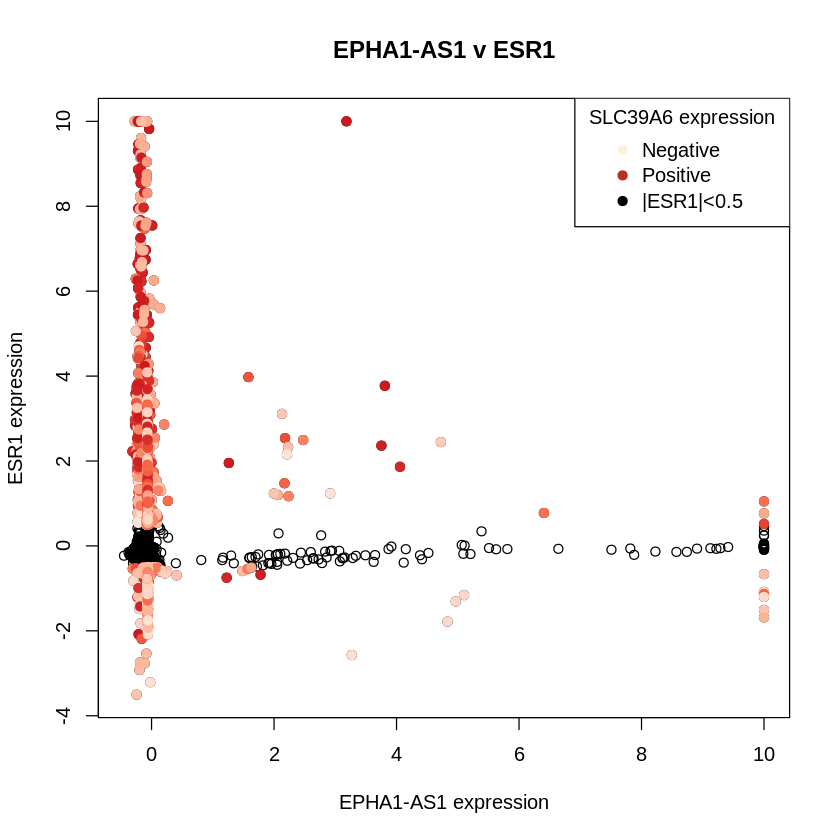

In [711]:
order = findInterval(X_diff$SLC39A6, sort(X_diff$SLC39A6))
cols = brewer.pal(4, "Reds")
pal = colorRampPalette(c("blue", "red"))
# Use the following line with RColorBrewer
pal = colorRampPalette(cols)
plot(X$EPHA1.AS1, Y, xlab="EPHA1-AS1 expression", ylab="ESR1 expression")
points(X_diff$EPHA1.AS1, Y_diff, pch=19, col=pal(nrow(X_diff))[order])
legend("topright", pch=19,col=c("#FFF0DB", "#BB2F29", "#000000"),
   legend=c("Negative", "Positive", "|ESR1|<0.5"), title="SLC39A6 expression")
title("EPHA1-AS1 v ESR1")

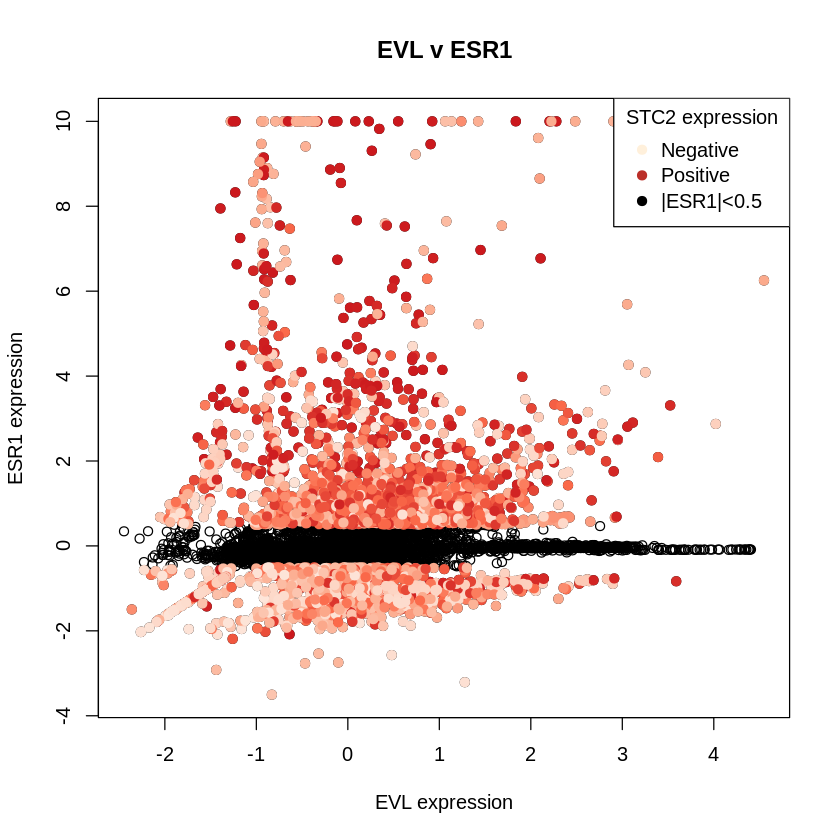

In [715]:
cols = brewer.pal(4, "Reds")
pal = colorRampPalette(c("blue", "red"))
# Use the following line with RColorBrewer
pal = colorRampPalette(cols)
plot(X$EVL, Y, xlab="EVL expression", ylab="ESR1 expression")
points(X_diff$EVL, Y_diff, pch=19, col=pal(nrow(X_diff))[order])
legend("topright", pch=19,col=c("#FFF0DB", "#BB2F29", "#000000"),
   legend=c("Negative", "Positive", "|ESR1|<0.5"), title="STC2 expression")
title("EVL v ESR1")

In [600]:
# list containing all the fitted models
#fit_list <- list.files(path='./',pattern="^fit")

# create a list containing the coefs and freq
param_list2 <- vector('list',2)

Beta_total <- rep(0, 14298)
hits_total <- rep(0, 14298)
# aggregating hits and beta coef
for (fit_mod in fit_list) {
    coef_list <- as.numeric(coef(fit_mod))
    hits_total <- hits_total + (coef_list!=0)*1
    Beta_total <- Beta_total + coef_list
}

Beta_total <- as.matrix(Beta_total)
hits_total <- as.matrix(hits_total)

Beta_avg <- Beta_total/100
Beta_avg_hits <- Beta_total/hits_total

for (i in 1:dim(Beta_total)[2]){
    param_list2[[i]] <- data.frame(Beta_avg[,i], Beta_avg_hits[,i],
                                hits_total[,i]/length(fit_list)*100
)
    param_list2 <- cbind(param_list2[[1]], rownames(coef(fit_mod)))
    colnames(param_list2) <- c('Coef_all', 'Coef_hits', 'Hits', 'Gene')
}

In [601]:
all_coefs <- matrix(, nrow = 100, ncol = dim(Beta_total)[1])

for (i in 1:100) {
    all_coefs[i,] <- as.numeric(coef(fit_list[[i]]))
}

In [602]:
all_coefs[all_coefs==0] <- NA

In [603]:
colnames(all_coefs) <- rownames(coef(fit_list[[i]]))

In [604]:
param_list2["SD"] <- NA

In [605]:
for (i in 1:dim(Beta_total)[1]) {
    s <- sd(all_coefs[,i], na.rm=TRUE)
    if (is.na(s) == FALSE) {
        param_list2[i,5] <- s
    }
}

In [606]:
param_list_stripped2<-param_list2[complete.cases(param_list2),]

In [612]:
write.csv(param_list_stripped2[order(abs(param_list_stripped2$Coef_all)),],"/home/severs/SingleCells/Lasso_parameter_list", row.names = FALSE)


In [610]:
param_list_stripped2[order(abs(param_list_stripped2$Coef_all)),]

,Coef_all,Coef_hits,Hits,Gene,SD
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
6536,2.078869e-05,0.001039434,2,RP11-37B2.1,0.0013440927
12685,6.081369e-05,0.003040685,2,SYCP2,0.0014981016
12549,1.139834e-04,0.005699171,2,LINC00657,0.0078716727
5954,1.430073e-04,0.007150366,2,MAGIX,0.0074962219
9250,1.483802e-04,0.007419009,2,CHPT1,0.0080968017
13754,1.550292e-04,0.002214703,7,ZNF552,0.0012364945
10317,1.628608e-04,0.008143042,2,TMEM62,0.0070708466
3243,1.649158e-04,0.008245788,2,LETM1,0.0100773115
3585,1.654076e-04,0.008270382,2,ANKRD50,0.0088558453


In [581]:
write.csv(param_list2,"/home/severs/SingleCells/Lasso_parameter_list_withzero", row.names = FALSE)



In [36]:
set.seed(2)
train.index <- createDataPartition(Y, p = .8, list = FALSE)

In [37]:
X_train1<- X[train.index,]

In [38]:
Y_train1<- Y[train.index]

In [39]:
X_test1<- X[-train.index,]

In [40]:
Y_test1 <- Y[-train.index]

The input is normalized (subtract mean, divide by std) on the training data which is used to normalize the test data.

In [41]:
normParam <- preProcess(X_train1)

In [42]:
norm.X_train1<- predict(normParam, X_train1)

In [43]:
norm.X_test1<- predict(normParam, X_test1)

In [44]:
lambdas <- 10^seq (-0.5, -3, by = -.05)

In [45]:
registerDoMC(cores = 20)

In [65]:
set.seed(2)
cv_lasso  <- cv.glmnet(as.matrix(norm.X_train1) , Y_train1,
                       nfolds = 5, alpha = 1, lambda = lambdas,
                       type.measure = "deviance", parallel=TRUE)

In [ ]:
prediction <- predict(cv_lasso, newx=as.matrix(norm.X_test1))

In [ ]:
pred <- data.frame(list(prediction, Y_test1))

In [ ]:
colnames(pred) <- c("prediction", "truth")

In [ ]:
pred <- pred[order(pred$truth),]

In [ ]:
r2score <- rsq(Y_test1, prediction)
rmsescore <- rmse(Y_test1, prediction)

In [ ]:
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression")
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 12988 cells with 14297 genes. Tested on 3247 cells.")

In [66]:
summary(cv_lasso)

           Length Class  Mode     
lambda     51     -none- numeric  
cvm        51     -none- numeric  
cvsd       51     -none- numeric  
cvup       51     -none- numeric  
cvlo       51     -none- numeric  
nzero      51     -none- numeric  
call        8     -none- call     
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  
index       2     -none- numeric  

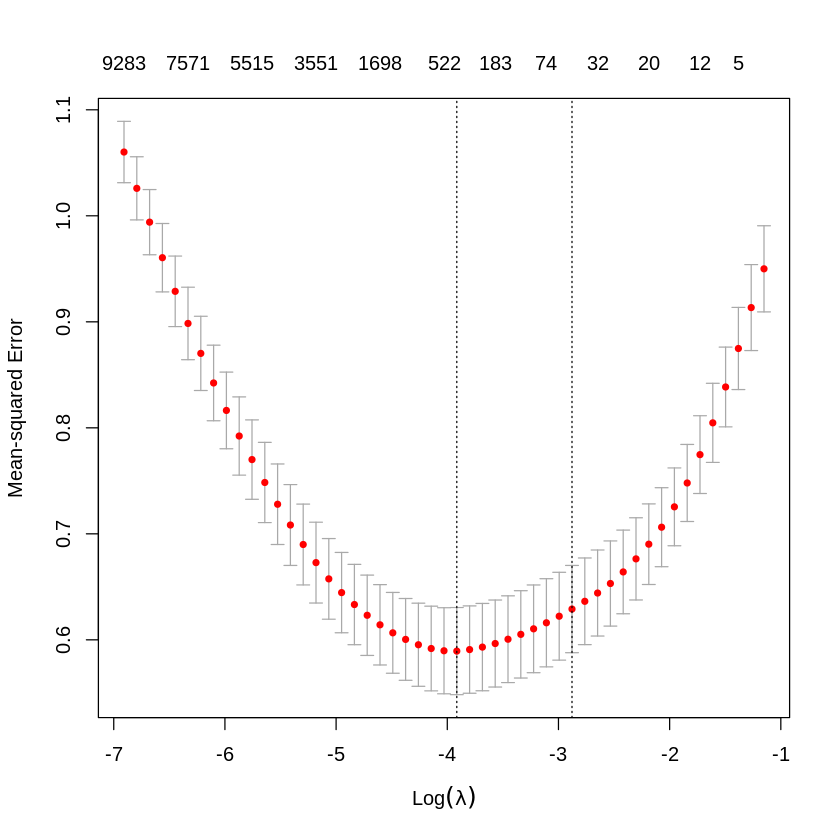

In [67]:
plot(cv_lasso)

In [73]:
coef(cv_lasso)

14298 x 1 sparse Matrix of class "dgCMatrix"
                               s1
(Intercept)          0.1233337044
FO538757.2           .           
AP006222.2           .           
RP11-206L10.9        .           
LINC00115            .           
FAM41C               .           
SAMD11               .           
NOC2L                .           
KLHL17               .           
PLEKHN1              .           
HES4                 .           
ISG15                .           
AGRN                 .           
C1orf159             .           
TTLL10               .           
TNFRSF18             .           
TNFRSF4              .           
SDF4                 .           
B3GALT6              .           
UBE2J2               .           
ACAP3                .           
PUSL1                .           
CPSF3L               .           
CPTP                 .           
TAS1R3               .           
DVL1                 .           
MXRA8                .           
AUR

In [ ]:
cv_lasso$lambda.1se/sum(abs(coef(cv_lasso)))
cv_lasso$lambda.min/sum(abs(coef(cv_lasso, s=cv_lasso$lambda.min)))

In [ ]:
lasso.mod <- glmnet(X_train, Y_train, alpha=1,  parallel=TRUE)

In [ ]:
par(mfrow = c(1,1), mar = c(3.5,3.5,2,1), mgp = c(2, 0.6, 0), cex = 0.8, las = 1)
plot(lasso.mod, xvar="lambda")
abline(v=log(cv_lasso$lambda.1se), col="red", lw=2, lty=2)

In [ ]:
biggest <- match(max(abs(coef(cv_lasso)[2:length(coef(cv_lasso))])),as.numeric(coef(cv_lasso)))

## Stratification on patient level with differentially expressed data

In [16]:
load("/data/xiaoral/rna_metadata.Rdata")

In [47]:
rownames(metadata.df) <- metadata.df$Cell

In [48]:
metadata.df$Cell <- NULL

In [49]:
set.seed(42)
train.index2 <- createDataPartition(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber[abs(Y)>0.5], p = .8, list = FALSE)

In [50]:
X_train2 <- X[abs(Y)>0.5,][train.index2,]
Y_train2 <- Y[abs(Y)>0.5][train.index2]

In [51]:
X_test2 <- X[abs(Y)>0.5,][-train.index2,]
Y_test2 <- Y[abs(Y)>0.5][-train.index2]

In [52]:
# Scaling

normParam2 <- preProcess(X_train2)
X_train2 <- predict(normParam2, X_train2)
X_test2 <- predict(normParam2, X_test2)

In [ ]:
lambdas2 <- 10^seq (0, -2.5, by = -.05)

In [ ]:
set.seed(42)
cv_lasso2  <- cv.glmnet(as.matrix(X_train2) , Y_train2, nfolds = 5, alpha = 1, lambda = lambdas2 , type.measure = "deviance", parallel=TRUE)

In [ ]:
plot(cv_lasso2)

In [ ]:
# Test on testset
prediction <- predict(cv_lasso2, newx=as.matrix(X_test2))
pred <- data.frame(list(prediction, Y_test2))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test2, prediction)
rmsescore <- rmse(Y_test2, prediction)

In [ ]:
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(1, min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 2768 cells, selecting 43 genes. \nTested on 691 cells. Stratified by patient.")

In [ ]:
"Number of genes"
sum(abs(coef(cv_lasso2, s = "lambda.1se"))>0)

## Stratification on patient level with all data

In [53]:
set.seed(2)
train.index3 <- createDataPartition(metadata.df[metadata.df$CellType=="Cancer", ]$PatientNumber, p = .8, list = FALSE)

In [54]:
X_train3 <- X[train.index3,]
Y_train3 <- Y[train.index3]

In [55]:
X_test3 <- X[-train.index3,]
Y_test3 <- Y[-train.index3]

In [58]:
# Scaling

normParam3 <- preProcess(X_train3)
X_train3 <- predict(normParam2, X_train3)
X_test3 <- predict(normParam2, X_test3)

In [ ]:
lambdas3 <- 10^seq (0.5, -3, by = -.05)

In [ ]:
set.seed(2)
cv_lasso3  <- cv.glmnet(as.matrix(X_train3) , Y_train3,
                        nfolds = 5, alpha = 1, lambda = lambdas3 ,
                        type.measure = "deviance", parallel=TRUE)

In [ ]:
sum(abs(coef(cv_lasso3))>0)

In [ ]:
plot(cv_lasso3)
title("Cross_validation of lambda on ESR1 stratified by patient.")

In [ ]:
# Test on testset
prediction <- predict(cv_lasso3, newx=as.matrix(X_test3))
pred <- data.frame(list(prediction, Y_test3))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test3, prediction)
rmsescore <- rmse(Y_test3, prediction)

In [ ]:
#pdf("/home/severs/SingleCells/plots/lasso_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("Lasso trained on 12990 cells, selecting 59 genes. \nTested on 3245 cells. Stratified by patient.")
#dev.off()

The results of stratification on patients and stratification on ESR1 are very similar and it seems like there is no effect. 
Stratification on patients and stratification on ESR1 are `cv_lasso3` and `cv_lasso` respectively.

# XGBoost 

Below XGBoost tree models are used on the two previous datasets. We see that on the full dataset, Lasso and XGBoost perform about the same, but on the subset with differentially expressed cells XGboost is a lot better than Lasso. 

XGBoost achieves an RMSE of 1.03 and R2 of 0.718 while Lasso has 1.999 and 0.173 respectively. These results are from the test set.

On the full dataset stratified by patient XGBoost and Lasso performs about the same. 

Keep in mind that the results for XGBoost are not cross validated and simply trained on one set and tested on another. Lasso achieved MSE at around 2.5 -> RMSE=1.58 in cross validation. There is no cross-validation procedure for XGBoost in R and I'll either implement one myself or do more rigorous testing in Python. 

In [57]:
library(xgboost)

## XGBoost on full dataset stratified by patient

In [59]:
set.seed(2)
xgb3 <- xgboost(data = as.matrix(X_train3), 
 label = Y_train3, 
 eta = 0.05,
 max_depth = 6, 
 nround=200, 
 subsample = 0.8,
 colsample_bytree = 0.8,
 eval_metric = "rmse",
 objective = "reg:squarederror",
 nthread = 40, 
 verbose=0
)

In [60]:
# Test on testset
prediction <- predict(xgb3, newdata=as.matrix(X_test3))
pred <- data.frame(list(prediction, Y_test3))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test3, prediction)
rmsescore <- rmse(Y_test3, prediction)

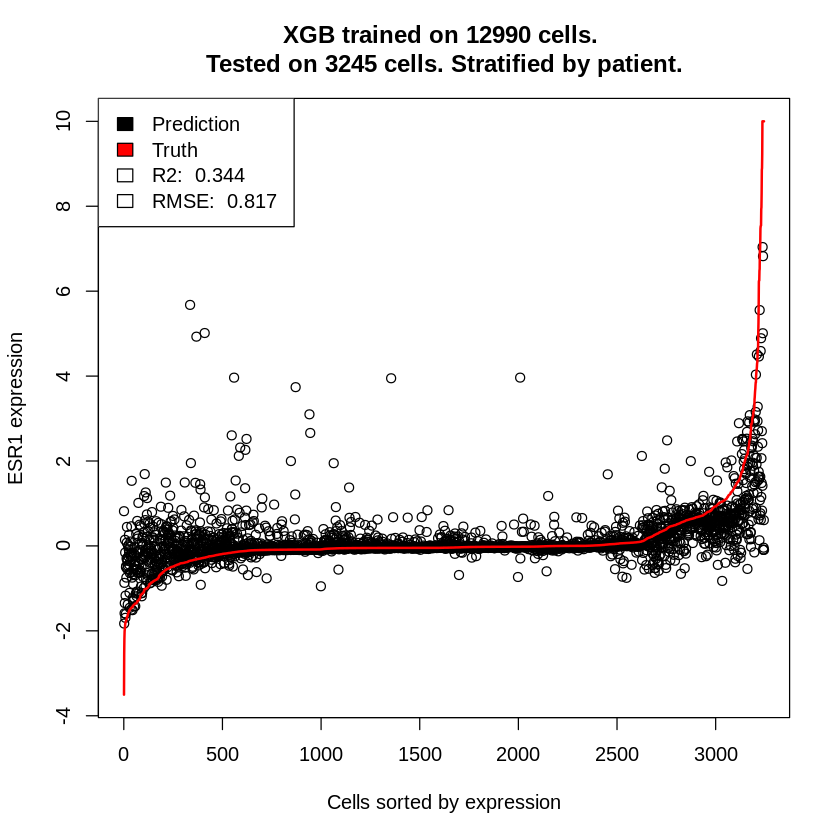

In [61]:
#pdf("/home/severs/SingleCells/plots/xgb_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("XGB trained on 12990 cells. \nTested on 3245 cells. Stratified by patient.")
#dev.off()

## XGBoost on differentially expressed subset stratified by patient 

In [62]:
set.seed(2)
xgb2 <- xgboost(data = as.matrix(X_train2), 
 label = Y_train2, 
 eta = 0.05,
 max_depth = 6, 
 nround=200, 
 subsample = 0.8,
 colsample_bytree = 0.8,
 eval_metric = "rmse",
 objective = "reg:squarederror",
 nthread = 40
)

[1]	train-rmse:1.937102 
[2]	train-rmse:1.870875 
[3]	train-rmse:1.806119 
[4]	train-rmse:1.744140 
[5]	train-rmse:1.688958 
[6]	train-rmse:1.633843 
[7]	train-rmse:1.583749 
[8]	train-rmse:1.536040 
[9]	train-rmse:1.491176 
[10]	train-rmse:1.444896 
[11]	train-rmse:1.400917 
[12]	train-rmse:1.358083 
[13]	train-rmse:1.317996 
[14]	train-rmse:1.281907 
[15]	train-rmse:1.245204 
[16]	train-rmse:1.212599 
[17]	train-rmse:1.182039 
[18]	train-rmse:1.152241 
[19]	train-rmse:1.120454 
[20]	train-rmse:1.092622 
[21]	train-rmse:1.064708 
[22]	train-rmse:1.040289 
[23]	train-rmse:1.015280 
[24]	train-rmse:0.993789 
[25]	train-rmse:0.974415 
[26]	train-rmse:0.955486 
[27]	train-rmse:0.936503 
[28]	train-rmse:0.917329 
[29]	train-rmse:0.897735 
[30]	train-rmse:0.883124 
[31]	train-rmse:0.866459 
[32]	train-rmse:0.851370 
[33]	train-rmse:0.837493 
[34]	train-rmse:0.822154 
[35]	train-rmse:0.809657 
[36]	train-rmse:0.796624 
[37]	train-rmse:0.784621 
[38]	train-rmse:0.772441 
[39]	train-rmse:0.760

In [63]:
# Test on testset
prediction <- predict(xgb2, newdata=as.matrix(X_test2))
pred <- data.frame(list(prediction, Y_test2))
colnames(pred) <- c("prediction", "truth")
pred <- pred[order(pred$truth),]
r2score <- rsq(Y_test2, prediction)
rmsescore <- rmse(Y_test2, prediction)

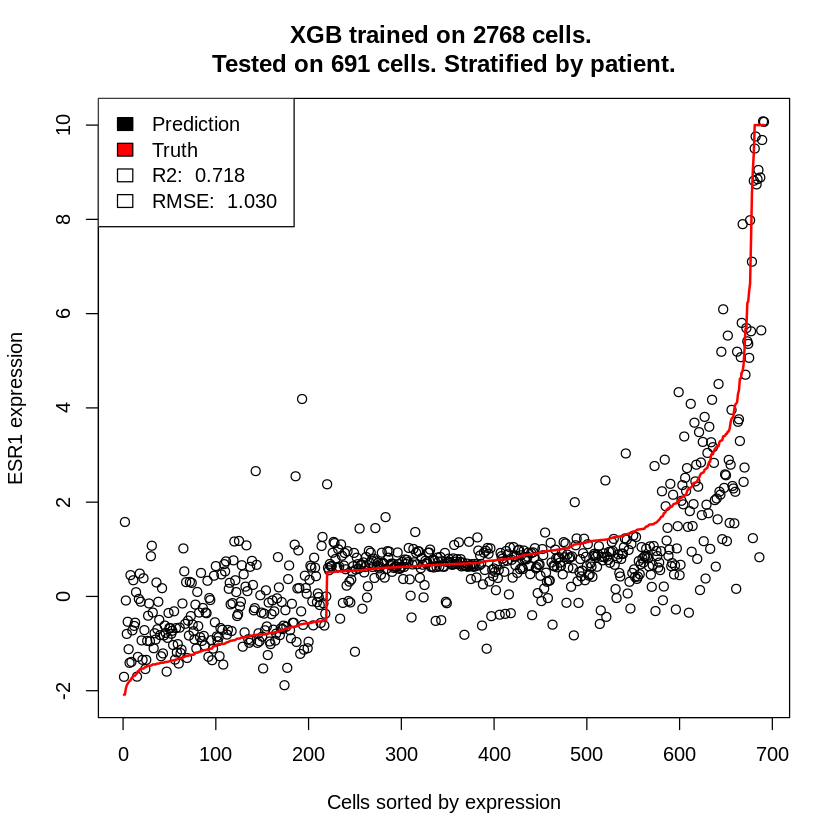

In [64]:
#pdf("/home/severs/SingleCells/plots/xgb_patient_strat.pdf")
plot(pred$prediction, pch=1, ylab="ESR1 expression", xlab="Cells sorted by expression",
     ylim=c(min(c(min(pred$prediction), min(pred$truth))), max(c(max(pred$prediction), max(pred$truth)))))
lines(pred$truth, col="red", lw=2)
legend("topleft", 
       legend=c("Prediction", "Truth",
                paste("R2: ", substr(toString(r2score), 1, 5)),
                paste("RMSE: ", substr(toString(rmsescore), 1, 5))),
       fill=c("black","red", "white", "white"))
title("XGB trained on 2768 cells. \nTested on 691 cells. Stratified by patient.")
#dev.off()



In [ ]:
#xgb.save(xgb3, "/data/severs/xgb_all.model")

In [ ]:
write.csv(train.index3, "/data/severs/trainind_patient_strat.csv")

In [ ]:
write.csv(train.index2, "/data/severs/trainind_patient_strat_diffexp.csv")

# Analysis of NeoLetExe metadata

In [ ]:
library("Seurat")

In [ ]:
load("/data/severs/NeoLetExe_five_triplets.RData")

In [ ]:
(Subset_Cells@meta.data)

In [ ]:
library("ggplot2")

In [ ]:
VlnPlot(Subset_Cells, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [ ]:
Subset_Cells

In [ ]:
VlnPlot(object = Subset_Cells, features = c("ESR2"))

In [ ]:
DimPlot(Subset_Cells)

In [ ]:
meta_data <- data.frame(Subset_Cells@meta.data)

In [ ]:

DimPlot(Subset_Cells, dims=c(1,2), reduction = "umap",label=TRUE)

#ggsave("/home/severs/SingleCells/plots/umap.png", height = 7 , width = 7 * 2)

In [ ]:
UMAP_coord <- as.data.frame(Subset_Cells[["umap"]]@cell.embeddings)

In [ ]:
UMAP_coord["patient_number"] <- meta_data["patient_number"]

In [ ]:
meta_data["UMAP_1"] <- UMAP_coord["UMAP_1"]
meta_data["UMAP_2"] <- UMAP_coord["UMAP_2"]

In [ ]:
write.csv(meta_data, "/data/severs/NeoLet_metadata.csv", row.names=TRUE)